# Imports and Functions

In [1]:
from sunlab.fortran_src.aae_flib_mamba import *
from sunlab.globals import *
from sunlab.common.plotting import *
from sunlab.common.mathlib.lyapunov import *
from sunlab.common.mathlib.random_walks import *
from sunlab.globals import FILES

In [2]:
from scipy.special import gamma
from scipy.optimize import curve_fit
# from tqdm.notebook import tqdm
# from numpy import pi, sin, cos, mean
import numpy as np
# from numpy.random import normal
# from matplotlib import pyplot as plt
import mistree as mist
from numpy import loadtxt

In [3]:
from scipy.signal import correlate2d

In [4]:
def get_trajectory_msds(trajectory, lag_count=10):
    """trajectories: (T, D)"""
    from numpy import asfortranarray
    from sunlab.fortran_src.aae_flib_mamba import mmsds
    X = asfortranarray(trajectory)
    return mmsds(X, lag_count)

def get_trajectories_msds(trajectories, lag_count=10):
    """trajectories: (T, N, D)"""
    from numpy import asfortranarray, array
    from sunlab.fortran_src.aae_flib_mamba import mmsds
    lags = []
    X = asfortranarray(trajectories)
    for seq in range(X.shape[1]):
        lags.append(mmsds(X[:,seq,:], lag_count))
    return array(lags).T

In [5]:
def sample_msds(method='grw', lag_count=10, **kwargs):
    method_dict = {
        'gs': get_gaussian_samples,
        'grw': get_gaussian_random_walks,
        'lf': get_levy_flights,
    }
    if method in method_dict.keys():
        method = method_dict[method]
    else:
        raise ValueError("Method Not Supported!")
    trajectories = method(**kwargs)
    msds = get_trajectories_msds(trajectories, lag_count=lag_count)
    return msds, trajectories

In [6]:
def find_longest_trajectory(trajectories):
    """# Find longest trajectory
    trajectories: [Dim, N_t, N]"""
    from numpy import argmin, argmax, isnan
    N = trajectories.shape[2]
    Longest = 0
    for n in range(N):
        X = trajectories[:,:,n].T # N_t x Dim
        X_max = min(trajectories.shape[1] - argmax(~isnan(X[::-1,:]), axis=0))
        X_min = max(argmin(isnan(X), axis=0))
        X = X[X_min:X_max,:]
        if Longest < X.shape[0]:
            Longest = X.shape[0]
    return Longest

In [7]:
def autocorrelate_trajectory(trajectories, middle_only=True):
    """# Autocorrelate Trajectory
    trajectories: [Dim, N_t, N]"""
    from numpy import zeros, bool_, argmin, argmax, isnan
    from numpy.ma import masked_where
    N = trajectories.shape[2]
    DimensionSize = 2 * trajectories.shape[0] - 1
    if middle_only:
        DimensionSize = 1
    CorrelationSize = 2 * find_longest_trajectory(trajectories) - 1
    CorrelationMid = trajectories.shape[0] - 1
    Correlation = zeros((CorrelationSize, DimensionSize * N))
    CorrelationMask = zeros((CorrelationSize, DimensionSize * N)).astype(bool_)
    for n in range(N):
        X = trajectories[:,:,n].T # N_t x Dim
        X_max = min(trajectories.shape[1] - argmax(~isnan(X[::-1,:]), axis=0))
        X_min = max(argmin(isnan(X), axis=0))
        X = X[X_min:X_max,:]
        correlation = correlate2d(X, X)
        if DimensionSize == 1:
            correlation = correlation[:,[CorrelationMid]]
        C_min = CorrelationSize // 2 - correlation.shape[0] // 2
        C_max = C_min + correlation.shape[0]
        Correlation[C_min:C_max,n*DimensionSize:(n+1)*DimensionSize] = correlation
        CorrelationMask[C_min:C_max,n*DimensionSize:(n+1)*DimensionSize] = True
    return Correlation, CorrelationMask, masked_where(~CorrelationMask, Correlation)

In [8]:
def plot_autocorrelation(correlation, normalize=False, **plot_kwargs):
    from numpy import nanmax
    correlation = correlation[2]
    if normalize:
        correlation /= nanmax(correlation)
    plt.plot(np.linspace(-correlation.shape[0]//2, correlation.shape[0]//2+1, correlation.shape[0]), correlation, **plot_kwargs)

In [9]:
def plot_trajectory_autocorrelation(trajectories, normalize=False, **plot_kwargs):
    plot_autocorrelation(autocorrelate_trajectory(trajectories), normalize=normalize, **plot_kwargs)

# Setup

In [10]:
g_D = 2       # Dimensionality
# g_D = 100       # Dimensionality
N_LAGS = 18   # Number of Lags

In [11]:
kwargs = {}
lfm, lft = sample_msds('lf', **kwargs)
grm, grt = sample_msds('grw', **kwargs)
gsm, gst = sample_msds('gs', **kwargs)

In [12]:
trace_data = loadtxt(DIR_ROOT + "extra_data/PEN_vec_10p_traces.npy", skiprows=1)

In [13]:
_N = 3
traces = []
taken = []
for _ in range(_N):
    trace = np.zeros((1,1))
    while trace.shape[0] < N_LAGS:
        trace = trace_data[trace_data[:,0] == np.random.randint(np.max(np.unique(trace_data[:,0]))),:]
        if trace[0,0] in taken:
            continue
        taken.append(trace[0,0])
    traces.append(trace)

In [14]:
_N_t = min([t.shape[0] for t in traces])
_rt_trajectories = np.zeros((_N,_N_t,2))
for index,trace in enumerate(traces):
    _rt_trajectories[index,...] = trace[:_N_t,2:]

In [15]:
rt_trajectories = _rt_trajectories.copy()
lf_trajectories = lft.copy()[1:,:_N,...].transpose(1,0,2)[:,:_N_t,:]
gr_trajectories = grt.copy()[1:,:_N,...].transpose(1,0,2)[:,:_N_t,:]
gs_trajectories = gst.copy()[1:,:_N,...].transpose(1,0,2)[:,:_N_t,:]

In [16]:
rt_trajectories.shape

(3, 24, 2)

In [17]:
rt_traces = [rt_trace for rt_trace in rt_trajectories]
gr_traces = [gr_trace for gr_trace in gr_trajectories]
lf_traces = [lf_trace for lf_trace in lf_trajectories]

In [18]:
[rt_trace.shape for rt_trace in rt_trajectories]

[(24, 2), (24, 2), (24, 2)]

In [19]:
rt_msds = np.array([mmsds(rt_trace, N_LAGS) for rt_trace in rt_trajectories])
gr_msds = np.array([mmsds(gr_trace, N_LAGS) for gr_trace in gr_trajectories])
lf_msds = np.array([mmsds(lf_trace, N_LAGS) for lf_trace in lf_trajectories])

In [20]:
rt_lps = Lyapunov_t(rt_trajectories)
gr_lps = Lyapunov_t(gr_trajectories)
lf_lps = Lyapunov_t(lf_trajectories)

In [21]:
rt_rds = RelativeDistance_t(rt_trajectories)
gr_rds = RelativeDistance_t(gr_trajectories)
lf_rds = RelativeDistance_t(lf_trajectories)

In [22]:
rt_autoc = autocorrelate_trajectory(rt_trajectories.transpose(2,1,0))
gr_autoc = autocorrelate_trajectory(gr_trajectories.transpose(2,1,0))
lf_autoc = autocorrelate_trajectory(lf_trajectories.transpose(2,1,0))

# Runtime Parameters

In [23]:
SAVE_EXTRAS = False

In [24]:
g_Base = lambda *args: DIR_ROOT + "Figures/RandomWalks/"

# Plots

## Traces

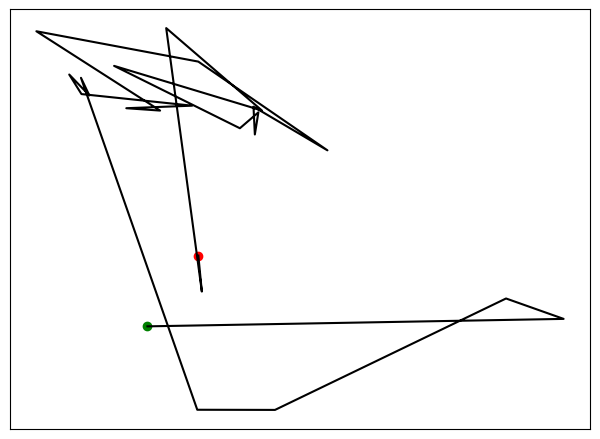

In [36]:
trace = rt_traces[0]
plt.plot(trace[:,-2],trace[:,-1], '-', color='black')
plt.scatter(trace[0,-2],trace[0,-1], c='r')
plt.scatter(trace[-1,-2],trace[-1,-1], c='g')

if SAVE_EXTRAS:
    plt.save(g_Base() + "Trajectories/18p_real_trajectory")

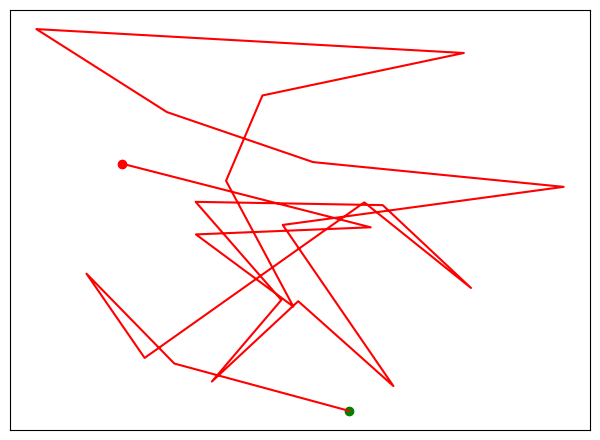

In [37]:
trace = lf_traces[0]
plt.plot(trace[:,-2],trace[:,-1], '-', color='red')
plt.scatter(trace[0,-2],trace[0,-1], c='r')
plt.scatter(trace[-1,-2],trace[-1,-1], c='g')
if SAVE_EXTRAS:
    plt.save(g_Base() + "Trajectories/levy")

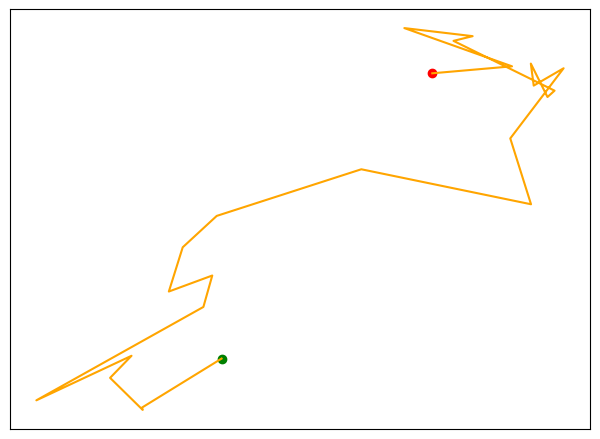

In [38]:
trace = gr_traces[0]
plt.plot(trace[:,-2],trace[:,-1], '-', color='orange')
plt.scatter(trace[0,-2],trace[0,-1], c='r')
plt.scatter(trace[-1,-2],trace[-1,-1], c='g')

if SAVE_EXTRAS:
    plt.save(g_Base() + "Trajectories/bounded_gaussian_rw")

## MSDs

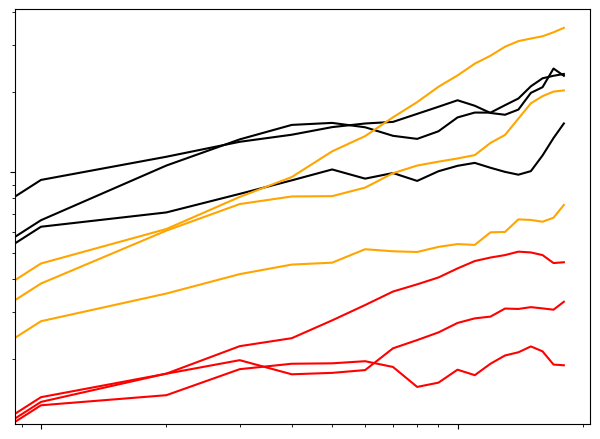

In [42]:
plt.loglog(rt_msds.T, c='black')
plt.loglog(gr_msds.T, c='orange')
plt.loglog(lf_msds.T, c='red')

if SAVE_EXTRAS:
    plt.save(g_Base() + "msd", _xticks=True, _yticks=True)

## Relative Separation

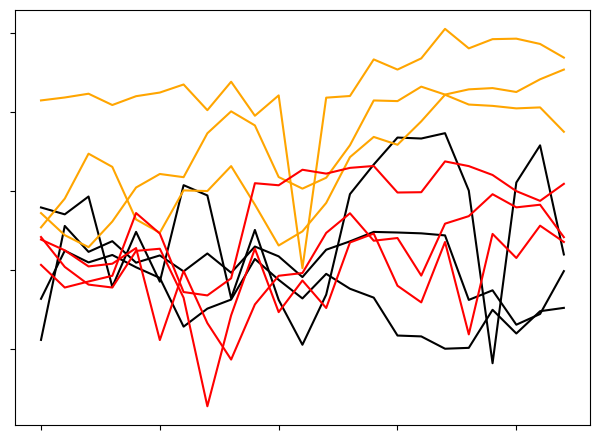

In [41]:
plt.plot(rt_rds.T, c='black')
plt.plot(gr_rds.T, c='orange')
plt.plot(lf_rds.T, c='red')

if SAVE_EXTRAS:
    plt.save(g_Base() + "relative_separation", _xticks=True, _yticks=True)

## Lyapunov

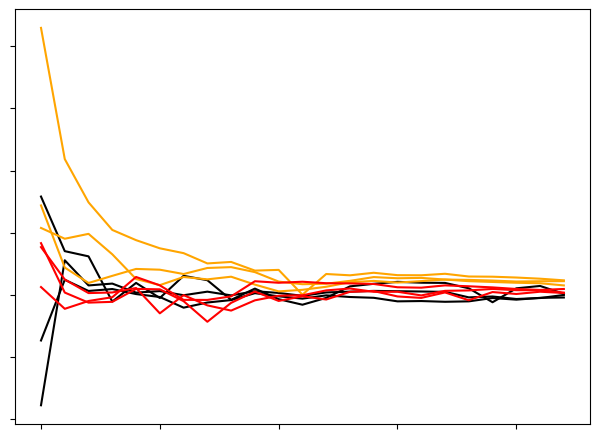

In [40]:
plt.plot(rt_lps.T, c='black')
plt.plot(gr_lps.T, c='orange')
plt.plot(lf_lps.T, c='red')

if SAVE_EXTRAS:
    plt.save(g_Base() + "lyapunov", _xticks=True, _yticks=True)

## Autocorrelation

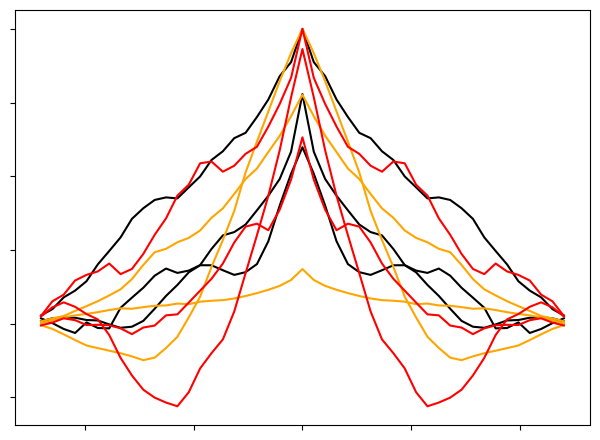

In [39]:
plot_autocorrelation(rt_autoc, normalize=True, color='black')
plot_autocorrelation(gr_autoc, normalize=True, color='orange')
plot_autocorrelation(lf_autoc, normalize=True, color='red')

if SAVE_EXTRAS:
    plt.save(g_Base() + "Autocorrelation/Combined", _xticks=True, _yticks=True)

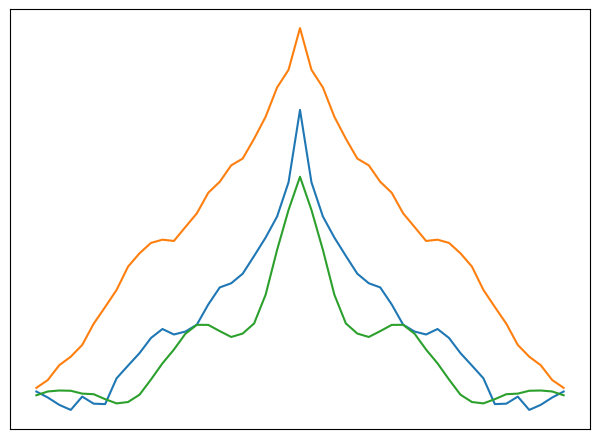

In [32]:
plot_autocorrelation(rt_autoc)

if SAVE_EXTRAS:
    plt.save(g_Base() + "Autocorrelation/RealTrajectories")

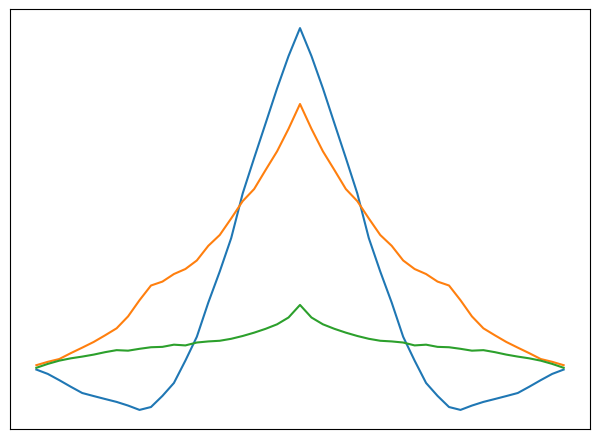

In [33]:
plot_autocorrelation(gr_autoc)

if SAVE_EXTRAS:
    plt.save(g_Base() + "Autocorrelation/BoundedGaussianRandomWalk")

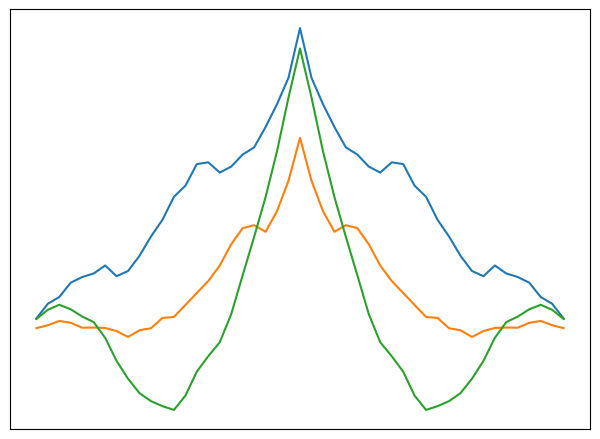

In [34]:
plot_autocorrelation(lf_autoc)

if SAVE_EXTRAS:
    plt.save(g_Base() + "Autocorrelation/LevyFlights")

# END